In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

### Data Preparation

In [2]:
# Read all files 

files = [file for file in os.listdir('./SalesAnalysis/Sales_Data')]

# Put dataframes of files into a list
frames = []

for file in files:
    frames.append(pd.read_csv("SalesAnalysis/Sales_Data/" + file))

In [3]:
# Concatenate dataframe list into a single dataframe

all_months = pd.concat(frames, keys = files)

In [4]:
# Check that all files were imported

all_months.index.get_level_values(0).unique()

Index(['Sales_April_2019.csv', 'Sales_August_2019.csv',
       'Sales_December_2019.csv', 'Sales_February_2019.csv',
       'Sales_January_2019.csv', 'Sales_July_2019.csv', 'Sales_June_2019.csv',
       'Sales_March_2019.csv', 'Sales_May_2019.csv', 'Sales_November_2019.csv',
       'Sales_October_2019.csv', 'Sales_September_2019.csv'],
      dtype='object')

In [5]:
# Promote file keys to their own column so that they don't get mixed up with index

all_months.reset_index(level=0, inplace=True)

In [6]:
# Remove rows which contain column names of concatenated dataframes

all_months = all_months[~((all_months['Order ID'] == 'Order ID') & (all_months['Product'] == 'Product'))]

# Remove rows that don't contain a number

all_months = all_months.dropna(axis = 0, subset = ['Order ID'])


### Q1 What was the best month for sales?

Ans.  The analysis below shows that December was the best month for sales in 2019. 

In [7]:
# Calculate sales 

all_months['Quantity Ordered'] = pd.to_numeric(all_months['Quantity Ordered'])
all_months['Price Each'] = pd.to_numeric(all_months['Price Each'])

all_months['Sales'] = all_months['Quantity Ordered'] * all_months['Price Each']

In [8]:
all_months.head()

,level_0,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Sales
0,Sales_April_2019.csv,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001",23.90
2,Sales_April_2019.csv,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215",99.99
3,Sales_April_2019.csv,176560,Google Phone,1,600.00,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001",600.00
4,Sales_April_2019.csv,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001",11.99
5,Sales_April_2019.csv,176561,Wired Headphones,1,11.99,04/30/19 09:27,"333 8th St, Los Angeles, CA 90001",11.99


In [9]:
all_months['Order Date'] = pd.to_datetime(all_months['Order Date'])
sales = all_months.groupby(all_months['Order Date'].dt.month).agg({'Sales' : np.sum})
sales.reset_index(level=0, inplace=True)
sales.head()

,Order Date,Sales
0,1,1.822257e+06
1,2,2.202022e+06
2,3,2.807100e+06
3,4,3.390670e+06
4,5,3.152607e+06


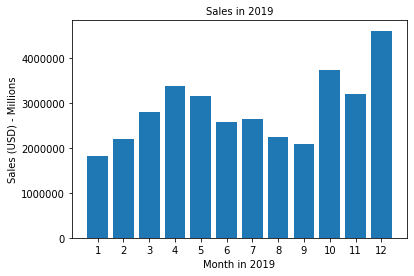

In [10]:
plt.figure()
plt.bar(sales['Order Date'], sales['Sales'])
plt.xticks(sales['Order Date'])
plt.ylabel('Sales (USD) - Millions')
plt.xlabel('Month in 2019')
plt.ticklabel_format(style = 'plain')
_ = plt.title(r"Sales in 2019", fontsize = 10)

### Q2 What city had the highest sales?

Ans.  San Francisco, CA, had the highest sales at USD 8.3 M

In [11]:
# Create new column, City after parsing Purchase Address column

pattern_city = "(?:[Ss]+[Tt]+, *)(?P<city>[\w]+ *[\w]+)(?P<state>, [\w]+)"
city_state = all_months['Purchase Address'].str.extract(pattern_city)
all_months['City'] = city_state['city'] + city_state['state']
all_months.head()

,level_0,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Sales,City
0,Sales_April_2019.csv,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",23.90,"Dallas, TX"
2,Sales_April_2019.csv,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",99.99,"Boston, MA"
3,Sales_April_2019.csv,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",600.00,"Los Angeles, CA"
4,Sales_April_2019.csv,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",11.99,"Los Angeles, CA"
5,Sales_April_2019.csv,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",11.99,"Los Angeles, CA"


In [12]:
# Group by City column, aggregate on sales

city_sales = all_months.groupby(['City']).agg({'Sales' : np.sum})
city_sales.sort_values(by = ['Sales'], ascending = False).head()

,Sales
City,
"San Francisco, CA",8.262204e+06
"Los Angeles, CA",5.452571e+06
"Boston, MA",3.661642e+06
"Atlanta, GA",2.795499e+06
"Dallas, TX",2.767975e+06


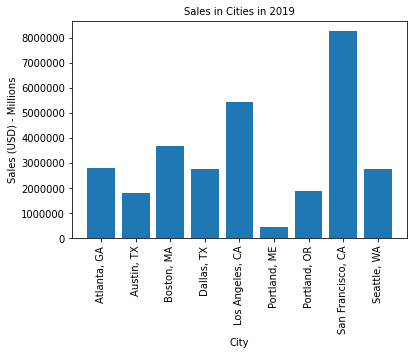

In [13]:
# Plot results
city_sales.reset_index(level=0, inplace=True)

plt.figure()
plt.bar(city_sales['City'], city_sales['Sales'])
_ = plt.xticks(city_sales['City'], rotation = 'vertical')
plt.ylabel('Sales (USD) - Millions')
plt.xlabel('City')
plt.ticklabel_format(style = 'plain', axis = 'y')
_ = plt.title(r"Sales in Cities in 2019", fontsize = 10)

### Q3 What time should advertisements be displayed to maximize chances of a customer buying product?

Ans.  Max sales occur from 11 am to 7 pm.  Better to display ads sometime before 11 am.

In [14]:
# Group by hour to find total sales by the hour over the whole year

hourly = all_months.groupby(all_months['Order Date'].dt.hour).agg({'Sales' : np.sum})
hourly.reset_index(level = 0, inplace = True)
hourly.head()

,Order Date,Sales
0,0,713721.27
1,1,460866.88
2,2,234851.44
3,3,145757.89
4,4,162661.01


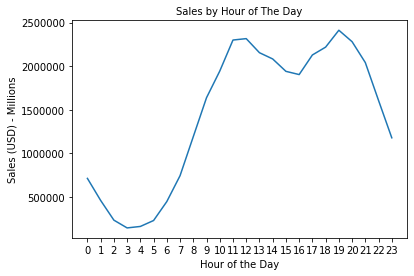

In [15]:
plt.figure()
plt.plot(hourly['Order Date'], hourly['Sales'])
_ = plt.xticks(hourly['Order Date'])
plt.ylabel('Sales (USD) - Millions')
plt.xlabel('Hour of the Day')
plt.ticklabel_format(style = 'plain')
_ = plt.title(r"Sales by Hour of The Day", fontsize = 10)

### Q4 What products were most often sold together?

Ans.  iPhone and Lightning Charging Cables were sold together as pairs, the most often.

In [16]:
# First get an idea of all the types of products sold 

all_months['Product'].unique()

array(['USB-C Charging Cable', 'Bose SoundSport Headphones',
       'Google Phone', 'Wired Headphones', 'Macbook Pro Laptop',
       'Lightning Charging Cable', '27in 4K Gaming Monitor',
       'AA Batteries (4-pack)', 'Apple Airpods Headphones',
       'AAA Batteries (4-pack)', 'iPhone', 'Flatscreen TV',
       '27in FHD Monitor', '20in Monitor', 'LG Dryer', 'ThinkPad Laptop',
       'Vareebadd Phone', 'LG Washing Machine', '34in Ultrawide Monitor'],
      dtype=object)

In [17]:
# Find orders with multiple items

dupli_order_id = all_months.duplicated(subset = ['Order ID'], keep = False)
multi_items = all_months[dupli_order_id].sort_values(by = ['Order ID'])
multi_items.head()

,level_0,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Sales,City
41,Sales_January_2019.csv,141275,USB-C Charging Cable,1,11.95,2019-01-07 16:06:00,"610 Walnut St, Austin, TX 73301",11.95,"Austin, TX"
42,Sales_January_2019.csv,141275,Wired Headphones,1,11.99,2019-01-07 16:06:00,"610 Walnut St, Austin, TX 73301",11.99,"Austin, TX"
58,Sales_January_2019.csv,141290,AA Batteries (4-pack),3,3.84,2019-01-02 08:25:00,"4 1st St, Los Angeles, CA 90001",11.52,"Los Angeles, CA"
57,Sales_January_2019.csv,141290,Apple Airpods Headphones,1,150.00,2019-01-02 08:25:00,"4 1st St, Los Angeles, CA 90001",150.00,"Los Angeles, CA"
133,Sales_January_2019.csv,141365,Vareebadd Phone,1,400.00,2019-01-10 11:19:00,"20 Dogwood St, New York City, NY 10001",400.00,NaN


In [18]:
# List comprehension to create list of lists. Not grouping by ['Order ID', 'Product ID'] because different products for same ID get grouped in different dataframes,
#making it more challending to combine them into a single list for same ID. 
combo_outer =[]

combo_outer = [row.values.tolist() for _, row in multi_items.groupby('Order ID')['Product']]
    
# Remove duplicate products for a given ID
main = []

for items in combo_outer:
    main.append(list(set(items)))

In [19]:
# Count the combinations
from itertools import combinations
from collections import Counter

count = Counter()

for row_list in main:
    count.update(Counter(combinations(row_list, 2)))

for key, value  in count.most_common():
    print(key, value)

('iPhone', 'Lightning Charging Cable') 998
('Google Phone', 'USB-C Charging Cable') 997
('Wired Headphones', 'iPhone') 461
('Wired Headphones', 'Google Phone') 421
('iPhone', 'Apple Airpods Headphones') 373
('Vareebadd Phone', 'USB-C Charging Cable') 368
('Google Phone', 'Bose SoundSport Headphones') 228
('Wired Headphones', 'USB-C Charging Cable') 203
('Wired Headphones', 'Lightning Charging Cable') 128
('AA Batteries (4-pack)', 'Lightning Charging Cable') 106
('Bose SoundSport Headphones', 'USB-C Charging Cable') 102
('Vareebadd Phone', 'Wired Headphones') 101
('Wired Headphones', 'Apple Airpods Headphones') 100
('Lightning Charging Cable', 'USB-C Charging Cable') 100
('AAA Batteries (4-pack)', 'USB-C Charging Cable') 95
('AAA Batteries (4-pack)', 'AA Batteries (4-pack)') 87
('Wired Headphones', 'AA Batteries (4-pack)') 83
('Vareebadd Phone', 'Bose SoundSport Headphones') 82
('AAA Batteries (4-pack)', 'Apple Airpods Headphones') 81
('AAA Batteries (4-pack)', 'Lightning Charging Cable

### Q5 What product sold the most, and why?

AAA batteries (4-pack) were the most ordered in 2019 at 31,017 units.  This is likely because AAA batteries are depletable products that power multiple consumer electronics within a single household, which would make them a high demand product.  This assumes that these are non-rechargeable.     

In [20]:
Total_sales = all_months.pivot_table(index = 'Product', values = 'Quantity Ordered', aggfunc= {'Quantity Ordered' : np.sum}) # Naming the aggfunc to avoid creating a multi-index

In [21]:
Total_sales.sort_values(by = ['Quantity Ordered'], ascending = False).head()

,Quantity Ordered
Product,
AAA Batteries (4-pack),31017
AA Batteries (4-pack),27635
USB-C Charging Cable,23975
Lightning Charging Cable,23217
Wired Headphones,20557
